On effectue le pricing de plusieurs options dans le modèle de Jacobi.

In [19]:
# Some useful imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import eval_hermitenorm, factorial
from scipy.stats import norm
from scipy.linalg import expm


from scipy.special import eval_hermitenorm, factorial
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import expm_multiply

On commence par pricer un call et une option digitale.

In [103]:
class JacobiPricing:
    def __init__(self, V0, X0, v_min, v_max, sigma, rho, kappa, theta, delta, mu_w, sigma_w, r):
        self.V0 = V0
        self.X0 = X0
        self.v_min = v_min
        self.v_max = v_max
        self.sigma = sigma
        self.rho = rho
        self.kappa = kappa
        self.theta = theta
        self.delta = delta
        self.mu_w = mu_w
        self.sigma_w = sigma_w
        self.r = r

    def Q(self, v):
        return (v-self.v_min) * (self.v_max-v) / (np.sqrt(self.v_max)-np.sqrt(self.v_min))**2
    
    def simulate_path(self, V0, X0, n_T, T):
        dt = T / n_T
        path = np.zeros((n_T+1, 2))
        path[0] = np.array([V0, X0])
        for i in range(1, n_T+1):
            Z = np.random.randn(2)
            Q_val = max(self.Q(path[i-1,0]), 0)
            path[i, 0] = path[i-1, 0] + self.kappa * (self.theta - path[i-1, 0]) * dt + self.sigma * np.sqrt(Q_val) * np.sqrt(dt) * Z[0]
            path[i, 1] = path[i-1, 1] + (self.r - self.delta - path[i-1, 0] / 2) * dt + self.rho * np.sqrt(Q_val) * np.sqrt(dt) * Z[0] + np.sqrt(max(0, path[i-1,0] - self.rho**2 * Q_val)) * np.sqrt(dt) * Z[1]
        return path

    def I_call(self, N, mu, nu):
        res = np.zeros(N+1)
        res[0] = np.exp(nu**2/2) * norm.cdf(nu-mu)
        for i in range(1, N+1):
            res[i] = eval_hermitenorm(i-1, mu) * np.exp(mu*nu) * norm.pdf(mu) + nu * res[i-1]
        return res

    def f_call(self, N, k, T):
        mu = (k-self.mu_w) / self.sigma_w
        nu = self.sigma_w
        I = self.I_call(N, mu, nu)
        f = np.zeros(N+1)
        f[0] = np.exp(-self.r*T+self.mu_w) * I[0] - np.exp(-self.r*T+k) * norm.cdf(-mu)
        for i in range(1, N+1):
            f[i] = np.exp(-self.r*T+self.mu_w) * (1/np.sqrt(factorial(i, exact=False))) * self.sigma_w * I[i-1]
        return f
    
    def f_digital(self, N, k, T):
        mu = (k-self.mu_w) / self.sigma_w
        nu = self.sigma_w
        f = np.zeros(N+1)
        f[0] = np.exp(-self.r * T) * norm.cdf(mu)
        for i in range(1, N+1):
            f[i] = (np.exp(-self.r*T) / np.sqrt(factorial(i, exact=False))) * eval_hermitenorm(i-1, -mu) * norm.pdf(-mu)
        return f
    
    def pi(self, N):
        p = 0
        h = {}
        h_inv = []
        for d in range(0, N+1):
            for i in range(0, d+1):
                h[(i, d-i)] = p
                h_inv.append((i, d-i))
                p += 1
        return h, np.array(h_inv)
    
    def H(self, m, n, v, x):
        return (v**m) * (1/np.sqrt(factorial(n, exact=False))) * eval_hermitenorm(n, (x-self.mu_w)/self.sigma_w)

    def l(self, N, T):
        M = (N+1) * (N+2) // 2
        h, h_inv = self.pi(N)
        l = np.zeros(N+1)

        H_lst = np.zeros(M)
        for i in range(M):
            (m, n) = h_inv[i]
            H_lst[i] = self.H(m, n, self.V0, self.X0)

        # Matrix G
        G = np.zeros((M, M))
        for d in range(0, N+1):
            for i in range(0, d+1):
                (m, n) = (i, d-i)
                if m >= 2:
                    G[h[(m-2,n)], h[(m,n)]] = -self.sigma**2 * m * (m-1) * self.v_max * self.v_min / (2 * (np.sqrt(self.v_max) - np.sqrt(self.v_min))**2)
                if m >=1 and n >= 1:
                    G[h[(m-1,n-1)], h[(m,n)]] = -self.sigma * self.rho * m * np.sqrt(n) * self.v_min * self.v_max / (self.sigma_w * (np.sqrt(self.v_max) - np.sqrt(self.v_min))**2)
                if m >= 1:
                    G[h[(m-1,n)], h[(m,n)]] = self.kappa * self.theta * m + (self.sigma**2 * m * (m-1) * (self.v_min + self.v_max)) / (2 * (np.sqrt(self.v_max) - np.sqrt(self.v_min))**2)
                if n >= 1:
                    G[h[(m,n-1)], h[(m,n)]] = (self.r-self.delta)*np.sqrt(n)/self.sigma_w + (self.sigma*self.rho*m*np.sqrt(n)*(np.sqrt(self.v_min)+np.sqrt(self.v_max))) / (self.sigma_w*(np.sqrt(self.v_max)-np.sqrt(self.v_min))**2)
                if n >=2 and m <= N-1:
                    G[h[(m+1,n-2)], h[(m,n)]] = np.sqrt(n*(n-1)) / (2 * self.sigma_w**2)
                G[h[(m,n)], h[(m,n)]] = -self.kappa * m - (self.sigma**2 * m * (m-1)) / (2*(np.sqrt(self.v_max) - np.sqrt(self.v_min))**2)
                if n >=1 and m <= N-1:
                    G[h[(m+1,n-1)], h[(m,n)]] = - np.sqrt(n) / (2*self.sigma_w) - (self.sigma * self.rho * m * np.sqrt(n)) / (2*(np.sqrt(self.v_max)-np.sqrt(self.v_min))**2)

        E = np.zeros((M, N+1))
        for i in range(N+1):
            E[h[(0, i)], i] = 1
        G_exp = expm(T * G) 

        l = H_lst @ G_exp @ E

        return l
    
    def price_call(self, N, k, T):
        f = self.f_call(N, k, T)
        l = self.l(N, T)
        return np.dot(f, l)
    
    def price_digital(self, N, k, T):
        f = self.f_digital(N, k, T)
        l = self.l(N, T)
        return np.dot(f, l)
    



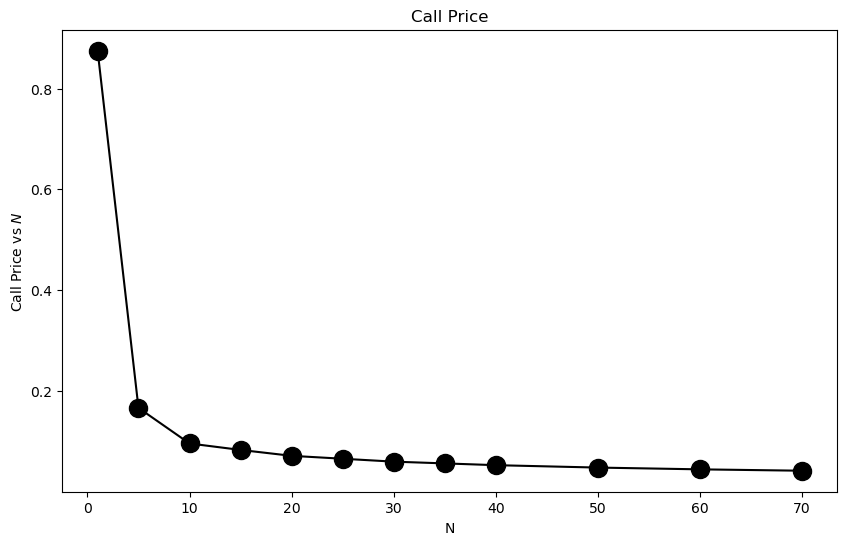

In [56]:
V0 = 0.04
X0 = 0.
v_min = 10**(-4)
v_max = 0.08
sigma = 1.
rho = -0.5
kappa = 0.5
theta = 0.04
delta = 0.
k = 0.
T = 1/12
r = 0.
sigma_w = sigma
mu_w = 0.1

model = JacobiPricing(V0, X0, v_min, v_max, sigma, rho, kappa, theta, delta, mu_w, sigma_w, r)

Ns = [1, 5, 10, 15, 20, 25, 30, 35, 40, 50, 60, 70]
call_prices = []

for N in Ns:
    prix_call = model.price_call(N, k, T)
    call_prices.append(prix_call)

# Tracé du graphe
plt.figure(figsize=(10, 6))
plt.plot(Ns, call_prices, marker='o', markersize=13, linestyle='-', color='black')
plt.xlabel("N")
plt.ylabel("Call Price vs $N$")
plt.title("Call Price")
plt.show()

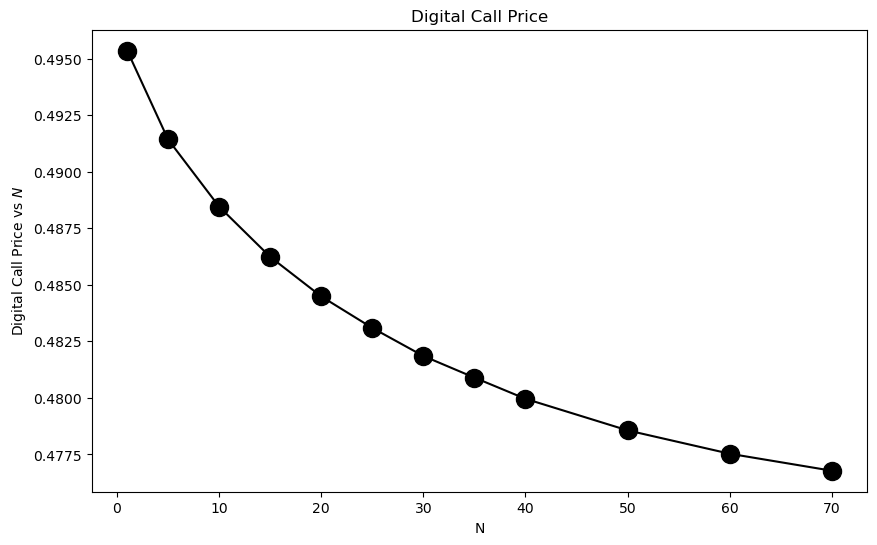

In [57]:
V0 = 0.04
X0 = 0.
v_min = 10**(-4)
v_max = 0.08
sigma = 1.
rho = -0.5
kappa = 0.5
theta = 0.04
delta = 0.
k = 0.
T = 1/12
r = 0.
sigma_w = sigma
mu_w = 0.005

model = JacobiPricing(V0, X0, v_min, v_max, sigma, rho, kappa, theta, delta, mu_w, sigma_w, r)

Ns = [1, 5, 10, 15, 20, 25, 30, 35, 40, 50, 60, 70]

digital_prices = []
for N in Ns:
    prix_digital = model.price_digital(N, k, T)
    digital_prices.append(prix_digital)

# Tracé du graphe
plt.figure(figsize=(10, 6))
plt.plot(Ns, digital_prices, marker='o', markersize=13, linestyle='-', color='black')
plt.xlabel("N")
plt.ylabel("Digital Call Price vs $N$")
plt.title("Digital Call Price")
plt.show()

On simule des trajectoires.

C:\Users\Maxence CAUCHETEUX\AppData\Local\Temp\ipykernel_18164\3414970360.py:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
C:\Users\Maxence CAUCHETEUX\AppData\Local\Temp\ipykernel_18164\3414970360.py:45: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


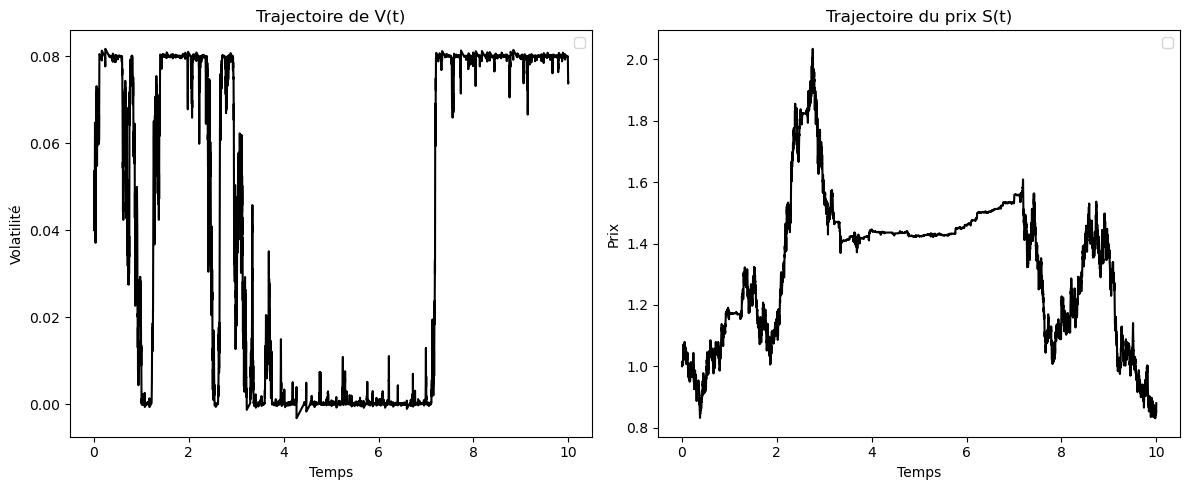

In [115]:
V0 = 0.04
X0 = 0.
v_min = 10**(-4)
v_max = 0.08
sigma = 1.
rho = -0.5
kappa = 0.5
theta = 0.04
delta = 0.
k = 0.
T = 1/12
r = 0.
sigma_w = sigma
mu_w = 0.005

model = JacobiPricing(V0, X0, v_min, v_max, sigma, rho, kappa, theta, delta, mu_w, sigma_w, r)

# Paramètres de simulation
T = 10       # horizon de temps (1 an)
n_T = 10000      # nombre de pas de temps

# Simuler la trajectoire (V_t, X_t)
path = model.simulate_path(model.V0, model.X0, n_T, T)

# Extraire les composantes
V = path[:, 0]  # volatilité
X = path[:, 1]  # log-prix
t = np.linspace(0, T, n_T+1)

# Tracer la trajectoire
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(t, V, color='black')
plt.xlabel('Temps')
plt.ylabel('Volatilité')
plt.title('Trajectoire de V(t)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(t, np.exp(X), color='black')
plt.xlabel('Temps')
plt.ylabel('Prix')
plt.title('Trajectoire du prix S(t)')
plt.legend()

plt.tight_layout()
plt.show()